In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.sparse as sps
from statsmodels.api import Logit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression, SGDClassifier
import sklearn

Here the results from 'Adult EDA" file are going to be used

In [66]:
# %run "Adult EDA.ipynb"

In [67]:
adult_columns = [
    "Age",
    "Workclass",
    "final weight",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Income",
]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                 header = None, names = adult_columns)

In [68]:
df = df.drop(['Education-Num'], axis = 'columns')

In [69]:
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [70]:
for col in categorical_features_list:
    print(f'{col}\n{df[col].value_counts()}\n')

Workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

Marital Status
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital Status, dtype: int64

Occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: 

As in the whole dataset (X) we have only one 'Holand-Netherlands' value in 'Country' column, we have to process it separately, because in case if it appears in the test set, model will not be able to predict target for such a record. For the initial model, where there are no changes in data, this observation will be removed

In [71]:
print(df.shape)
df_no_nl = df.copy()
df_no_nl.drop(df_no_nl.loc[df['Country']==' Holand-Netherlands'].index, inplace=True)
print(df_no_nl.shape)

(32561, 14)
(32560, 14)


In [72]:
X = df_no_nl.drop(['Income'], axis = 'columns')
y = df_no_nl['Income']

## 1. Features preprocessing

First, all variables have to be transformed to numerical format to feed them to LogisticRegression function:

In [73]:
X_train = X.copy()
y_train = y.copy()

In [74]:
X_train.head()

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In this dataset we have only one feature, where the order matters - Education, so it will be transformed with using OrdinalEncoder. For all the rest of categorical features the order does not matter, hense we can apply OneHotEncoder() to them.

# 1st model 
### Inital model without changes in data

In [75]:
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [76]:
def get_LR_performance (X, y, numerical_features_list: list, categorical_features_list:list):
    """The function performs data preprocessing, creates pipeline with LogisticRegression model, 
        and prints it's performance out

    Args:
        X (Series object): X_train DataFrame of features
        y (array): y_train - target
        numerical_features_list (list): list of features, that have to be processed by Standard scaler
        categorical_features_list (list): list of features, that have to be processed by OneHotEncoder
    """
    columntransformer = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                      ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                      ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
     make_column_selector(pattern = 'Education')),
    ('stand scaler', StandardScaler(), numerical_features_list),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='drop')
    
    pipe = make_pipeline(columntransformer, LogisticRegression(max_iter=500)).fit(X, y)
    
    y_pred = pipe.predict(X)
    
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    
    f1_mean_score = round(np.mean(scores),2)
    f1_std = round(np.std(scores),2)
    
    report = classification_report(y, y_pred, target_names=y_train.unique())
    print(f'f1 score: mean = {f1_mean_score} | std = {f1_std}\n{report}')


In [77]:
get_LR_performance(X_train, y_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.0
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     24719
        >50K       0.74      0.61      0.66      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.77      0.79     32560
weighted avg       0.85      0.85      0.85     32560



### Let's now understand significance of features with the help of Logit() function from statsmodel

In [78]:
def logit_summary(X, y, numerical_features: list, categorical_features: list):
    """Function performs data preprocessing and applies Logit() function. After that retuns summary which contains featues significances

    Args:
        X (Series object): X_train DataFrame of features
        y (array): y_train - target
        numerical_features_list (list): list of features, that have to be processed by Standard scaler
        categorical_features_list (list): list of features, that have to be processed by OneHotEncoder

    Returns:
        Summary: summary of statsmodel Logit() model with the help of which the decision about 
                keeping or modifying/removing a feature can be made
    """
    column_transformer = ColumnTransformer(transformers = [
        ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                          ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                          ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
         make_column_selector(pattern = 'Education')),
        ('stand_scaler', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features)],
        remainder='drop')
    
    X_trans = column_transformer.fit_transform(X)
    
    if sps.issparse(X_trans):
        X_trans = X_trans.toarray()
        
    x_columns_names = column_transformer.get_feature_names_out()
    X_trans = pd.DataFrame(X_trans, columns = x_columns_names)
    
    y_train_df = pd.DataFrame(y)
    onehot = OneHotEncoder(dtype='int', drop='first')
    y_trans = onehot.fit_transform(y_train_df)
    y_column_name = onehot.get_feature_names_out()
    y_trans = pd.DataFrame.sparse.from_spmatrix(y_trans, columns=y_column_name)
    
    model = Logit(y_trans, X_trans).fit_regularized()
    summary = model.summary()
    
    return summary

In [79]:
summary = logit_summary(X_train, y_train, numerical_features_list, categorical_features_list)
summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3216011168148676
            Iterations: 528
            Function evaluations: 531
            Gradient evaluations: 528


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Income_ >50K   No. Observations:                32560
Model:                          Logit   Df Residuals:                    32476
Method:                           MLE   Df Model:                           83
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.4174
Time:                        21:57:41   Log-Likelihood:                -10471.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
ordinal__Education                                0.2519      0.009     27.967      0.000       0.234       0.270
stand_scaler__Age                                 0.3264      0.022     14.865      0.000       0.283       0.369
stand_scaler__final weight                        0.0797      0.018      4.431      0.000       0.044       0.115
stand_scaler__Capital Gain                        2.3494      0.076     30.866      0.000       2.200       2.499
stand_scaler__Capital Loss                        0.2600      0.015     17.533      0.000       0.231       0.289
stand_scaler__Hours per week                      0.3755      0.020     18.994      0.000       0.337       0.414
onehot__Workclass_ Federal-gov                    0.7518   8.43e+05   8.92e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Local-gov                      0.0791   8.43e+05   9.38e-08      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Never-worked                  -1.5895      4.701     -0.338      0.735     -10.803       7.624
onehot__Workclass_ Private                        0.2586   8.43e+05   3.07e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Self-emp-inc                   0.4537   8.43e+05   5.38e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Self-emp-not-inc              -0.2024   8.43e+05   -2.4e-07      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ State-gov                     -0.0070   8.43e+05  -8.32e-09      1.000   -1.65e+06    1.65e+06
onehot__Workclass_ Without-pay                   -5.1518   8.43e+05  -6.11e-06      1.000   -1.65e+06    1.65e+06
onehot__Marital Status_ Married-AF-spouse        -2.2625      0.549     -4.122      0.000      -3.338      -1.187
onehot__Marital Status_ Married-civ-spouse       -2.7228      0.248    -10.957      0.000      -3.210      -2.236
onehot__Marital Status_ Married-spouse-absent    -0.2130      0.226     -0.941      0.347      -0.657       0.231
onehot__Marital Status_ Never-married            -0.6429      0.085     -7.576      0.000      -0.809      -0.477
onehot__Marital Status_ Separated                -0.2754      0.161     -1.705      0.088      -0.592       0.041
onehot__Marital Status_ Widowed                  -0.0457      0.151     -0.303      0.762      -0.341       0.250
onehot__Occupation_ Adm-clerical                  0.0755   8.43e+05   8.96e-08      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Armed-Forces                 -0.7952   8.43e+05  -9.43e-07      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Craft-repair                  0.1321   8.43e+05   1.57e-07      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Exec-managerial               0.8982   8.43e+05   1.07e-06      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Farming-fishing              -0.9294   8.43e+05   -1.1e-06      1.000   -1.65e+06    1.65e+06
onehot__Occupation_ Handlers-cleaners            

# 2nd model
### Same model, but without 'final weight'

As we remember from EDA, **'final weight'** feature did not pass the significance border. Let's try to remove it and check the performance

In [80]:
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [81]:
get_LR_performance(X_train, y_train, numerical_features_list, categorical_features_list)

/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1 score: mean = 0.78 | std = 0.0
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     24719
        >50K       0.73      0.61      0.66      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.77      0.78     32560
weighted avg       0.85      0.85      0.85     32560



#### Let's check if features' significances have changed

In [82]:
summary = logit_summary(X_train, y_train, numerical_features_list, categorical_features_list)
summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.32190023737059703
            Iterations: 522
            Function evaluations: 524
            Gradient evaluations: 522


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Income_ >50K   No. Observations:                32560
Model:                          Logit   Df Residuals:                    32477
Method:                           MLE   Df Model:                           82
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.4169
Time:                        21:58:02   Log-Likelihood:                -10481.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
ordinal__Education                                0.2517      0.009     27.955      0.000       0.234       0.269
stand_scaler__Age                                 0.3209      0.022     14.650      0.000       0.278       0.364
stand_scaler__Capital Gain                        2.3516      0.076     30.897      0.000       2.202       2.501
stand_scaler__Capital Loss                        0.2593      0.015     17.510      0.000       0.230       0.288
stand_scaler__Hours per week                      0.3734      0.020     18.900      0.000       0.335       0.412
onehot__Workclass_ Federal-gov                    0.7640        nan        nan        nan         nan         nan
onehot__Workclass_ Local-gov                      0.0951        nan        nan        nan         nan         nan
onehot__Workclass_ Never-worked                  -1.6768      4.808     -0.349      0.727     -11.100       7.746
onehot__Workclass_ Private                        0.2765        nan        nan        nan         nan         nan
onehot__Workclass_ Self-emp-inc                   0.4644        nan        nan        nan         nan         nan
onehot__Workclass_ Self-emp-not-inc              -0.1875        nan        nan        nan         nan         nan
onehot__Workclass_ State-gov                      0.0076        nan        nan        nan         nan         nan
onehot__Workclass_ Without-pay                   -5.2479        nan        nan        nan         nan         nan
onehot__Marital Status_ Married-AF-spouse        -2.2962      0.549     -4.181      0.000      -3.373      -1.220
onehot__Marital Status_ Married-civ-spouse       -2.7647      0.249    -11.124      0.000      -3.252      -2.278
onehot__Marital Status_ Married-spouse-absent    -0.2251      0.227     -0.993      0.321      -0.669       0.219
onehot__Marital Status_ Never-married            -0.6413      0.085     -7.561      0.000      -0.808      -0.475
onehot__Marital Status_ Separated                -0.2630      0.161     -1.630      0.103      -0.579       0.053
onehot__Marital Status_ Widowed                  -0.0492      0.151     -0.327      0.744      -0.345       0.246
onehot__Occupation_ Adm-clerical                  0.0577        nan        nan        nan         nan         nan
onehot__Occupation_ Armed-Forces                 -0.7358        nan        nan        nan         nan         nan
onehot__Occupation_ Craft-repair                  0.1102        nan        nan        nan         nan         nan
onehot__Occupation_ Exec-managerial               0.8762        nan        nan        nan         nan         nan
onehot__Occupation_ Farming-fishing              -0.9719        nan        nan        nan         nan         nan
onehot__Occupation_ Handlers-cleaners            -0.6498        nan        nan        nan         nan         nan
onehot__Occupation_ Machine-op-inspct            

According to Logit() results, all of numerical features are statistically significant. Some categoties in a couple of categotical features have to be clustered as they are insignificant. 
1. Workclasses representatives, that do not work or work without pay will deffinetely have less than 50k, so can become one cluster.
2. From Marital Status feature we can cluster together those, who have no partner and those who have
3. All categories of Occupation are insignificant, so could be removed from the model. But before, they will be left like this, as from the EDA we saw that this feature is significant
3. All categories of Relationship, Ethnic Group and Sex features are significant.
4. Most of countries have no impact on target, it's possible to cluster them by the part of the world. 

In [83]:
# feature_names = second.named_steps["columntransformer"].get_feature_names_out()
# coefs = second.named_steps["logisticregression"].coef_.flatten()
# zipped = zip(feature_names, coefs)
# df = pd.DataFrame(zipped, columns=["feature", "value"])
# df["abs_value"] = df["value"].apply(lambda x: abs(x))
# df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
# df = df.sort_values("abs_value", ascending=False)

# fig, ax = plt.subplots(1, 1, figsize=(7, 12))
# sns.barplot(x="value",
#             y="feature",
#             data=df,
#            palette=df["colors"])
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
# ax.set_title("Top Features", fontsize=20)
# ax.set_ylabel("Feature Name", fontsize=15)
# ax.set_xlabel("Coef", fontsize=15)

# 3rd model
### Clustering categories of features


In [84]:
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [85]:
X_clustered = X_train.copy()
X_clustered['Workclass'] = X_clustered['Workclass'].replace({' Without-pay': 'Non profitable', 
                                                             ' Never-worked': 'Non profitable', 
                                                             ' Self-emp-not-inc': 'Non profitable', 
                                                             ' Federal-gov': 'Government',  
                                                             ' State-gov': 'Government', 
                                                             ' Local-gov': 'Government'})
X_clustered['Relationship'] = X_clustered['Relationship'].replace({' Unmarried': ' Not-in-family', 
                                                                   ' Husband': ' Not-in-family',  
                                                                   ' Wife': ' Not-in-family', 
                                                                   ' Own-child': ' Not-in-family'})
X_clustered['Marital Status'] = X_clustered['Marital Status'].replace({' Widowed': 'Single',  
                                                                       ' Separated': 'Single',
                                                                       ' Married-spouse-absent': 'Single', 
                                                                       ' Never-married': 'Single', 
                                                                       ' Divorced': 'Single', 
                                                                       ' Married-civ-spouse': 'Married', 
                                                                       ' Married-AF-spouse': 'Married'})
X_clustered['Country'] = X_clustered['Country'].replace({' Mexico': 'Americas', 
                                                           ' Canada': 'Americas', 
                                                           ' Puerto-Rico': 'Americas', 
                                                           ' El-Salvador': 'Americas', 
                                                           ' Cuba': 'Americas', 
                                                           ' Jamaica': 'Americas', 
                                                           ' Dominican-Republic': 'Americas', 
                                                           ' Guatemala': 'Americas', 
                                                           ' Columbia': 'Americas', 
                                                           ' Haiti': 'Americas', 
                                                           ' Peru': 'Americas', 
                                                           ' Nicaragua': 'Americas', 
                                                           ' Ecuador': 'Americas', 
                                                           ' Trinadad&Tobago': 'Americas', 
                                                           ' Outlying-US(Guam-USVI-etc)': 'Americas', 
                                                           ' Honduras': 'Americas', 
                                                           ' India': 'Asia', 
                                                           ' China': 'Asia', 
                                                           ' South': 'Asia', 
                                                           ' Vietnam': 'Asia', 
                                                           ' Japan': 'Asia',
                                                           ' Taiwan': 'Asia', 
                                                           ' Thailand': 'Asia', 
                                                           ' Laos': 'Asia', 
                                                           ' Hong': 'Asia',
                                                           ' Philippines': 'Asia', 
                                                           ' Iran': 'Asia',
                                                           ' Cambodia': 'Asia',
                                                           ' Germany': 'Europe',
                                                           ' England': 'Europe', 
                                                           ' Italy': 'Europe',
                                                           ' Poland': 'Europe', 
                                                           ' Portugal': 'Europe', 
                                                           ' France': 'Europe', 
                                                           ' Greece': 'Europe', 
                                                           ' Ireland': 'Europe', 
                                                           ' Yugoslavia': 'Europe',
                                                           ' Hungary': 'Europe',
                                                           ' Scotland': 'Europe'})

In [86]:
X_clustered.head()

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,Government,77516,Bachelors,Single,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Non profitable,83311,Bachelors,Married,Exec-managerial,Not-in-family,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,Single,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,Married,Handlers-cleaners,Not-in-family,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,Married,Prof-specialty,Not-in-family,Black,Female,0,0,40,Americas


Let's now apply the pipeline to updated dataset

In [87]:
get_LR_performance(X_clustered, y_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.01
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     24719
        >50K       0.74      0.60      0.66      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.76      0.78     32560
weighted avg       0.84      0.85      0.85     32560



In [88]:
summary = logit_summary(X_clustered, y_train, numerical_features_list, categorical_features_list)
summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3283789492361
            Iterations: 254
            Function evaluations: 256
            Gradient evaluations: 254


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Income_ >50K   No. Observations:                32560
Model:                          Logit   Df Residuals:                    32526
Method:                           MLE   Df Model:                           33
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.4051
Time:                        21:58:11   Log-Likelihood:                -10692.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ordinal__Education                           0.2278      0.008     27.238      0.000       0.211       0.244
stand_scaler__Age                            0.3599      0.020     17.777      0.000       0.320       0.400
stand_scaler__Capital Gain                   2.3666      0.075     31.607      0.000       2.220       2.513
stand_scaler__Capital Loss                   0.2671      0.015     18.131      0.000       0.238       0.296
stand_scaler__Hours per week                 0.3933      0.019     20.343      0.000       0.355       0.431
onehot__Workclass_ Private                  -0.4158      3.392     -0.123      0.902      -7.064       6.232
onehot__Workclass_ Self-emp-inc             -0.2300      3.393     -0.068      0.946      -6.879       6.419
onehot__Workclass_Government                -0.4429      3.392     -0.131      0.896      -7.091       6.206
onehot__Workclass_Non profitable            -0.8841      3.391     -0.261      0.794      -7.531       5.762
onehot__Marital Status_Single               -2.4931      0.047    -53.228      0.000      -2.585      -2.401
onehot__Occupation_ Adm-clerical             0.5643      3.391      0.166      0.868      -6.082       7.211
onehot__Occupation_ Armed-Forces            -0.4101      3.654     -0.112      0.911      -7.573       6.752
onehot__Occupation_ Craft-repair             0.5159      3.391      0.152      0.879      -6.131       7.162
onehot__Occupation_ Exec-managerial          1.3522      3.391      0.399      0.690      -5.294       7.999
onehot__Occupation_ Farming-fishing         -0.6002      3.393     -0.177      0.860      -7.250       6.049
onehot__Occupation_ Handlers-cleaners       -0.2597      3.393     -0.077      0.939      -6.910       6.391
onehot__Occupation_ Machine-op-inspct        0.1429      3.392      0.042      0.966      -6.505       6.791
onehot__Occupation_ Other-service           -0.3952      3.392     -0.117      0.907      -7.044       6.253
onehot__Occupation_ Priv-house-serv         -3.5680      3.775     -0.945      0.345     -10.968       3.832
onehot__Occupation_ Prof-specialty           1.1540      3.391      0.340      0.734      -5.493       7.801
onehot__Occupation_ Protective-serv          0.9880      3.393      0.291      0.771      -5.661       7.637
onehot__Occupation_ Sales                    0.7911      3.391      0.233      0.816      -5.855       7.438
onehot__Occupation_ Tech-support             1.2139      3.392      0.358      0.720      -5.434       7.862
onehot__Occupation_ Transport-moving         0.2956      3.392      0.087      0.931      -6.352       6.943
onehot__Relationship_ Other-relative        -0.8535      0.207     -4.129      0.000      -1.259      -0.448
onehot__Ethnic group_ Asian-Pac-Islander    -1.9079      0.181    -10.524      0.000      -2.263      -1.553
onehot__Ethnic group_ Black                 -1.8475      0.134    -13.798      0

The performance for the minority class is now worse than before, so we can make a conclusion, that clustering categories in this way does not perform well

# 4th model
### Let's try to cluster 'Country' in another way



In [89]:
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Marital Status', 'Occupation', 'Workclass',
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [90]:
X_clustered = X_train.copy()
X_clustered['Workclass'] = X_clustered['Workclass'].replace({' Without-pay': 'Non profitable', 
                                                             ' Never-worked': 'Non profitable', 
                                                             ' Self-emp-not-inc': 'Non profitable', 
                                                             ' Federal-gov': 'Government',  
                                                             ' State-gov': 'Government', 
                                                             ' Local-gov': 'Government'})

def cluster_categorical(X):
    
  X['Relationship'] = X['Relationship'].replace({' Unmarried': ' Not-in-family', 
                                                                    ' Husband': ' Not-in-family',  
                                                                    ' Wife': ' Not-in-family', 
                                                                    ' Own-child': ' Not-in-family'})
  X['Marital Status'] = X['Marital Status'].replace({' Widowed': 'Single',  
                                                                        ' Separated': 'Single',
                                                                        ' Married-spouse-absent': 'Single', 
                                                                        ' Never-married': 'Single', 
                                                                        ' Divorced': 'Single', 
                                                                        ' Married-civ-spouse': 'Married', 
                                                                        ' Married-AF-spouse': 'Married'})
  X['Country'] = X['Country'].replace({' United-States': 'Developed', 
                                                           ' Mexico': 'Developing', 
                                                           ' Canada': 'Developed', 
                                                           ' Puerto-Rico': 'Developed', 
                                                           ' El-Salvador': 'Developing', 
                                                           ' Cuba': 'Developing', 
                                                           ' Jamaica': 'Developing', 
                                                           ' Dominican-Republic': 'Developing', 
                                                           ' Guatemala': 'Developing', 
                                                           ' Columbia': 'Developing', 
                                                           ' Haiti': 'Developing', 
                                                           ' Peru': 'Developing', 
                                                           ' Nicaragua': 'Developing', 
                                                           ' Ecuador': 'Developing', 
                                                           ' Trinadad&Tobago': 'Developing', 
                                                           ' Outlying-US(Guam-USVI-etc)': 'Developing', 
                                                           ' Honduras': 'Developing', 
                                                           ' India': 'Developing', 
                                                           ' China': 'Developing', 
                                                           ' South': 'Developing', 
                                                           ' Vietnam': 'Developing', 
                                                           ' Japan': 'Developed',
                                                           ' Taiwan': 'Developed', 
                                                           ' Thailand': 'Developing', 
                                                           ' Laos': 'Developing', 
                                                           ' Hong': 'Developed',
                                                           ' Philippines': 'Developing', 
                                                           ' Iran': 'Developing',
                                                           ' Cambodia': 'Developing',
                                                           ' Germany': 'Developed',
                                                           ' England': 'Developed', 
                                                           ' Italy': 'Developed',
                                                           ' Poland': 'Developing', 
                                                           ' Portugal': 'Developing', 
                                                           ' France': 'Developed', 
                                                           ' Greece': 'Developing', 
                                                           ' Ireland': 'Developing', 
                                                           ' Yugoslavia': 'Developing',
                                                           ' Hungary': 'Developing',
                                                           ' Scotland': 'Developed'})
  return X

X_clustered = cluster_categorical(X_clustered)

In [91]:
get_LR_performance(X_clustered, y_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.01
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     24719
        >50K       0.74      0.60      0.66      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.77      0.78     32560
weighted avg       0.85      0.85      0.85     32560



In [92]:
summary = logit_summary(X_clustered, y_train, numerical_features_list, categorical_features_list)
summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3280483864800765
            Iterations: 252
            Function evaluations: 255
            Gradient evaluations: 252


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Income_ >50K   No. Observations:                32560
Model:                          Logit   Df Residuals:                    32527
Method:                           MLE   Df Model:                           32
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.4057
Time:                        21:58:25   Log-Likelihood:                -10681.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ordinal__Education                           0.2291      0.008     27.371      0.000       0.213       0.245
stand_scaler__Age                            0.3676      0.020     18.109      0.000       0.328       0.407
stand_scaler__final weight                   0.0863      0.018      4.871      0.000       0.052       0.121
stand_scaler__Capital Gain                   2.3661      0.075     31.595      0.000       2.219       2.513
stand_scaler__Capital Loss                   0.2680      0.015     18.170      0.000       0.239       0.297
stand_scaler__Hours per week                 0.3962      0.019     20.482      0.000       0.358       0.434
onehot__Marital Status_Single               -2.4996      0.047    -53.332      0.000      -2.591      -2.408
onehot__Occupation_ Adm-clerical             0.5880      3.453      0.170      0.865      -6.179       7.355
onehot__Occupation_ Armed-Forces            -0.4268      3.719     -0.115      0.909      -7.716       6.862
onehot__Occupation_ Craft-repair             0.5403      3.453      0.156      0.876      -6.227       7.307
onehot__Occupation_ Exec-managerial          1.3754      3.453      0.398      0.690      -5.391       8.142
onehot__Occupation_ Farming-fishing         -0.5610      3.454     -0.162      0.871      -7.331       6.209
onehot__Occupation_ Handlers-cleaners       -0.2334      3.455     -0.068      0.946      -7.004       6.537
onehot__Occupation_ Machine-op-inspct        0.1681      3.453      0.049      0.961      -6.600       6.936
onehot__Occupation_ Other-service           -0.3637      3.454     -0.105      0.916      -7.133       6.405
onehot__Occupation_ Priv-house-serv         -3.5237      3.834     -0.919      0.358     -11.038       3.991
onehot__Occupation_ Prof-specialty           1.1762      3.453      0.341      0.733      -5.591       7.943
onehot__Occupation_ Protective-serv          1.0032      3.454      0.290      0.771      -5.766       7.773
onehot__Occupation_ Sales                    0.8105      3.453      0.235      0.814      -5.956       7.577
onehot__Occupation_ Tech-support             1.2375      3.453      0.358      0.720      -5.531       8.006
onehot__Occupation_ Transport-moving         0.3111      3.453      0.090      0.928      -6.457       7.079
onehot__Workclass_ Private                  -0.4274      3.453     -0.124      0.902      -7.196       6.341
onehot__Workclass_ Self-emp-inc             -0.2340      3.454     -0.068      0.946      -7.004       6.536
onehot__Workclass_Government                -0.4549      3.454     -0.132      0.895      -7.224       6.314
onehot__Workclass_Non profitable            -0.8882      3.453     -0.257      0.797      -7.655       5.879
onehot__Relationship_ Other-relative        -0.8351      0.206     -4.045      0.000      -1.240      -0.431
onehot__Ethnic group_ Asian-Pac-Islander    -1.6934      0.157    -10.764      0

Country is still sighniffacant, but all categories of Workclass and Occupation variables are insignifficant. Let's try to apply 'label encoder' to them instead of 'one hot encoder'
# 5th model

In [93]:
categorical_features_list = ['Marital Status','Relationship', 'Ethnic group', 'Country', 'Sex']
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Occupation', 'Workclass']

In [94]:
X_clustered = X_train.copy()

le  = LabelEncoder()

X_clustered['Workclass'] = le.fit_transform(X_clustered['Workclass'])
X_clustered['Occupation'] = le.fit_transform(X_clustered['Occupation'])

X_clustered = cluster_categorical(X_clustered)

In [95]:
X_clustered.sample()

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
24347,38,4,192930,HS-grad,Single,12,Not-in-family,White,Female,0,0,10,Developed


In [96]:
get_LR_performance(X_clustered, y_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.77 | std = 0.01
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90     24719
        >50K       0.72      0.57      0.63      7841

    accuracy                           0.84     32560
   macro avg       0.80      0.75      0.77     32560
weighted avg       0.84      0.84      0.84     32560



In [97]:
summary = logit_summary(X_clustered, y_train, numerical_features_list, categorical_features_list)
summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3418058795568492
            Iterations: 109
            Function evaluations: 111
            Gradient evaluations: 109


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Income_ >50K   No. Observations:                32560
Model:                          Logit   Df Residuals:                    32544
Method:                           MLE   Df Model:                           15
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.3808
Time:                        21:58:31   Log-Likelihood:                -11129.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ordinal__Education                           0.3088      0.007     43.110      0.000       0.295       0.323
stand_scaler__Age                            0.3559      0.019     18.620      0.000       0.318       0.393
stand_scaler__Capital Gain                   2.3873      0.073     32.568      0.000       2.244       2.531
stand_scaler__Capital Loss                   0.2743      0.014     19.024      0.000       0.246       0.303
stand_scaler__Hours per week                 0.3939      0.018     21.584      0.000       0.358       0.430
stand_scaler__Occupation                     0.0714      0.017      4.134      0.000       0.038       0.105
stand_scaler__Workclass                     -0.0463      0.017     -2.679      0.007      -0.080      -0.012
onehot__Marital Status_Single               -2.4988      0.046    -54.651      0.000      -2.588      -2.409
onehot__Relationship_ Other-relative        -0.9631      0.205     -4.692      0.000      -1.365      -0.561
onehot__Ethnic group_ Asian-Pac-Islander    -1.9850      0.146    -13.562      0.000      -2.272      -1.698
onehot__Ethnic group_ Black                 -2.2320      0.121    -18.410      0.000      -2.470      -1.994
onehot__Ethnic group_ Other                 -2.7673      0.283     -9.774      0.000      -3.322      -2.212
onehot__Ethnic group_ White                 -1.9720      0.107    -18.511      0.000      -2.181      -1.763
onehot__Country_Developed                   -1.0986      0.097    -11.352      0.000      -1.288      -0.909
onehot__Country_Developing                  -1.5335      0.127    -12.069      0.000      -1.782      -1.284
onehot__Sex_ Male                           -0.1199      0.046     -2.581      0.010      -0.211      -0.029
============================================================================================================
"""

All features are now significant, but the performance of model in total and especially for the minority class is now worse.
# 6th model

Let's try to remove missing data

In [98]:
X_no_missing_values = X_train.copy()
y_no_missing_values = y_train.copy()
df_no_missing_values = pd.concat([X_no_missing_values, y_no_missing_values], axis = 1)
df_no_missing_values = df_no_missing_values[df_no_missing_values['Workclass'] != ' ?']
df_no_missing_values = df_no_missing_values[df_no_missing_values['Occupation'] != ' ?']
df_no_missing_values = df_no_missing_values[df_no_missing_values['Country'] != ' ?']
X_no_missing_values = df_no_missing_values.drop(['Income'], axis=1)
y_no_missing_values = df_no_missing_values['Income']

In [99]:
df_no_missing_values

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [100]:
print(X_no_missing_values.shape, y_no_missing_values.shape)
print(X_train.shape, y_train.shape)

(30161, 13) (30161,)
(32560, 13) (32560,)


In [101]:
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']

In [102]:
X_no_missing_values = cluster_categorical(X_no_missing_values)

In [103]:
get_LR_performance(X_no_missing_values, y_no_missing_values, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.01
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     22653
        >50K       0.74      0.60      0.67      7508

    accuracy                           0.85     30161
   macro avg       0.81      0.77      0.78     30161
weighted avg       0.84      0.85      0.84     30161



This approach to data preprocessing gave us the best result so far - performance is just a bit better than we had for initial model. It's still not a good model though
# 7th model
### Let's try to apply ln() function to 'Age', 'Capital Gain' and 'Capital Loss' festures (as they are heavy tailed) before Standard Scaler to normalize it

In [104]:
X_logged = X_train.copy()

In [105]:
X_logged['Capital Gain'] = np.log(1+ X_logged['Capital Gain'])
X_logged['Capital Loss'] = np.log(1+ X_logged['Capital Loss'])
X_logged['Age'] = np.log(X_logged['Age'])

X_logged = cluster_categorical(X_logged)

In [106]:
get_LR_performance(X_logged, y_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.77 | std = 0.0
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     24719
        >50K       0.72      0.59      0.65      7841

    accuracy                           0.85     32560
   macro avg       0.80      0.76      0.78     32560
weighted avg       0.84      0.85      0.84     32560



Not better either.
# 8th model
### Another try is to cluster 'Hours per week' feature to part-time, fulltime and overtime workers with fulltime value for 40 hours

In [107]:
X_new = X_train.copy()
X_new['Hours per week'] = np.where(X_new['Hours per week'] == 40, 'fulltime', 
                                   (np.where(X_new['Hours per week'] < 40, 'part-time', 'overtime')))

X_new['Capital Gain'] = np.log(1+ X_new['Capital Gain'])
X_new['Capital Loss'] = np.log(1+ X_new['Capital Loss'])
X_new['Age'] = np.log(X_new['Age'])

X_new = cluster_categorical(X_new)

X_new = X_new.drop(['final weight'], axis='columns')

In [108]:
X_new.head()

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,3.663562,State-gov,Bachelors,Single,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,fulltime,Developed
1,3.912023,Self-emp-not-inc,Bachelors,Married,Exec-managerial,Not-in-family,White,Male,0.000000,0.0,part-time,Developed
2,3.637586,Private,HS-grad,Single,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,fulltime,Developed
3,3.970292,Private,11th,Married,Handlers-cleaners,Not-in-family,Black,Male,0.000000,0.0,fulltime,Developed
4,3.332205,Private,Bachelors,Married,Prof-specialty,Not-in-family,Black,Female,0.000000,0.0,fulltime,Developing


In [109]:
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country', 'Hours per week']

In [110]:
columntransformer = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                      ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                      ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
     make_column_selector(pattern = 'Education')),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='passthrough')
    
pipe = make_pipeline(columntransformer, LogisticRegression(max_iter=1000)).fit(X_new, y_train)

y_pred = pipe.predict(X_new)

scores = cross_val_score(pipe, X_new, y_train, cv=5, scoring='f1_macro')

f1_mean_score = round(np.mean(scores),2)
f1_std = round(np.std(scores),2)

report = classification_report(y_train, y_pred, target_names=y_train.unique())
print(f'f1 score: mean = {f1_mean_score} | std = {f1_std}\n{report}')

f1 score: mean = 0.78 | std = 0.0
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     24719
        >50K       0.72      0.59      0.65      7841

    accuracy                           0.85     32560
   macro avg       0.80      0.76      0.78     32560
weighted avg       0.84      0.85      0.84     32560



# 9th model
### Lets now try to cluster all minority categories of imbalanced features together

In [111]:
X_cluster2 = X_train.copy()
def balance_predictors(X):
    X['Ethnic group'] = np.where(X['Ethnic group'] != ' White', 'Other', X['Ethnic group'])
    X['Country'] = np.where(X['Country'] != ' United-States', 'Other', X['Country'])
    X['Workclass'] = np.where(X['Workclass'] != ' Private', 'Other', X['Workclass'])
    X['Marital Status'] = np.where(((X['Marital Status'] == ' Widowed') |
                                    (X['Marital Status'] == ' Married-spouse-absent') |
                                    (X['Marital Status'] == ' Separated')), 
                                    'Other', X_train['Marital Status'])
    X['Occupation'] = np.where(((X['Occupation'] == ' Adm-clerical') |
                                (X['Occupation'] == ' Armed-Forces') |
                                (X['Occupation'] == ' Craft-repair') |
                                (X['Occupation'] == ' Machine-op-inspct') |
                                (X['Occupation'] == ' Priv-house-serv') |
                                (X['Occupation'] == ' Transport-moving')), 
                                'Other', X['Occupation'])
    X['Hours per week'] = np.where(X['Hours per week'] == 40, 'fulltime', (np.where(X['Hours per week'] < 40, 'part-time', 'overtime')))
    
balance_predictors(X_cluster2)
X_cluster2.sample(3)

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
11719,32,Private,194981,HS-grad,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,part-time,United-States
28734,41,Other,153132,Assoc-acdm,Other,Other,Not-in-family,White,Male,0,0,overtime,United-States
31976,40,Private,259307,Some-college,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,overtime,United-States


In [112]:
numerical_features_list = ['Age', 'Capital Gain', 'Capital Loss']
categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country', 'Hours per week']

In [113]:
get_LR_performance(X_cluster2, y_train, numerical_features_list, categorical_features_list)

f1 score: mean = 0.78 | std = 0.01
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     24719
        >50K       0.74      0.59      0.66      7841

    accuracy                           0.85     32560
   macro avg       0.81      0.76      0.78     32560
weighted avg       0.84      0.85      0.85     32560



# Now let's try to find the threshold for optimal recall and precisoin values as the dataset is imbalanced and predicts minority class much worse yet

In [185]:
X_10 = X_train.copy()
y_10 = y_train.copy()
y_10.sample()

5025     <=50K
Name: Income, dtype: object

In [186]:
# preform data transformation as we used for initial model

categorical_features_list = ['Workclass', 'Marital Status', 'Occupation', 
                             'Relationship', 'Ethnic group', 'Sex', 'Country']
numerical_features_list = ['Age', 'final weight', 'Capital Gain', 'Capital Loss', 'Hours per week']

column_transformer = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                        ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                        ' Bachelors',' Masters',' Prof-school',' Doctorate']]),
        make_column_selector(pattern = 'Education')),
    ('minmax_scaler', MinMaxScaler(), numerical_features_list),
    ('onehot', OneHotEncoder(dtype='int', drop='first'), categorical_features_list)],
    remainder='drop')

X_10 = column_transformer.fit_transform(X_10)

if sps.issparse(X_10):
    X_10 = X_10.toarray()
    
x_columns_names = column_transformer.get_feature_names_out()
X_10 = pd.DataFrame(X_10, columns = x_columns_names)

In [187]:
y_10 = (y_10 == ' >50K')

In [188]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_10, y_10)

SGDClassifier(random_state=42)

In [207]:
lg_clf = LogisticRegression(max_iter=500, random_state=42)
lg_clf.fit(X_10, y_10)

LogisticRegression(max_iter=500, random_state=42)

In [189]:
print(sgd_clf.predict([X_10.iloc[1]]), y_10.iloc[1])

[False] False


/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [208]:
print(lg_clf.predict([X_10.iloc[1]]), y_10.iloc[1])

[False] False


/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [190]:
cross_val_score(sgd_clf, X_10, y_10, cv=3, scoring="f1_macro")

array([0.77458549, 0.57112112, 0.77814829])

In [209]:
cross_val_score(lg_clf, X_10, y_10, cv=3, scoring="f1_macro")

array([0.77539957, 0.780789  , 0.78488023])

In [191]:
y_10_pred_sgd = cross_val_predict(sgd_clf, X_10, y_10, cv=3)
confusion_matrix(y_10, y_10_pred_sgd)

array([[22495,  2224],
       [ 3701,  4140]])

In [210]:
y_10_pred_lg = cross_val_predict(lg_clf, X_10, y_10, cv=3)
confusion_matrix(y_10, y_10_pred_lg)

array([[23005,  1714],
       [ 3170,  4671]])

In [193]:
y_10_scores_sgd = sgd_clf.decision_function([X_10.iloc[90]])
y_10_scores_sgd

/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([0.17755519])

In [211]:
y_10_scores_lg = lg_clf.decision_function([X_10.iloc[90]])
y_10_scores_lg

/Users/nadiiaduiunova/opt/anaconda3/envs/final_env/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0.48263906])

In [212]:
y_10_scores_sgd = cross_val_predict(sgd_clf, X_10, y_10, cv=3, method="decision_function")
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_10, y_10_scores_sgd)

In [213]:
y_10_scores_lg = cross_val_predict(lg_clf, X_10, y_10, cv=3, method="decision_function")
precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_10, y_10_scores_lg)

In [214]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

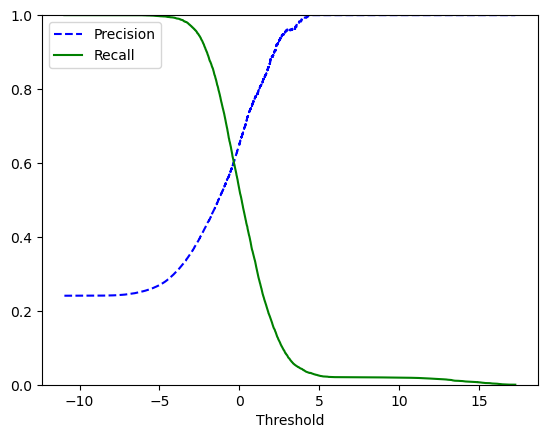

In [215]:
plot_precision_recall_vs_threshold(precisions_sgd, recalls_sgd, thresholds_sgd)
plt.show()

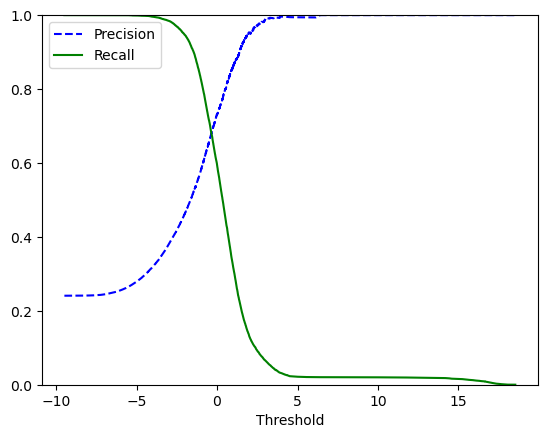

In [216]:
plot_precision_recall_vs_threshold(precisions_lg, recalls_lg, thresholds_lg)
plt.show()

In [221]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_10, y_10_scores_sgd)
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_10, y_10_scores_lg)

In [218]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


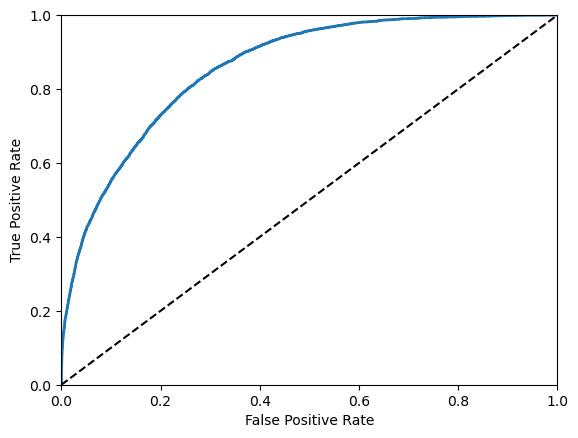

In [219]:
plot_roc_curve(fpr_sgd, tpr_sgd)
plt.show()

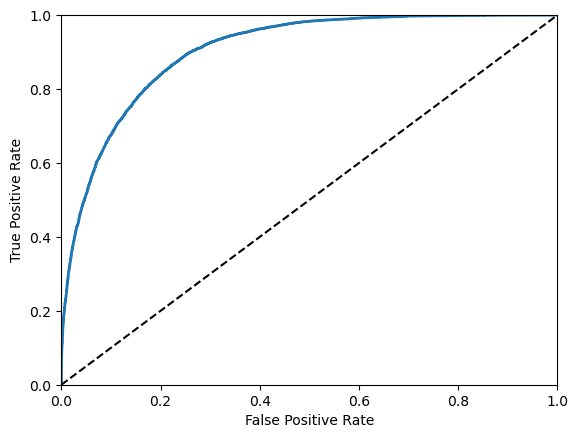

In [222]:
plot_roc_curve(fpr_lg, tpr_lg)
plt.show()

# Now let's try Random Forest classifier model

In [202]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_10, y_10, cv=3, method="predict_proba")

In [203]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_10, y_scores_forest)

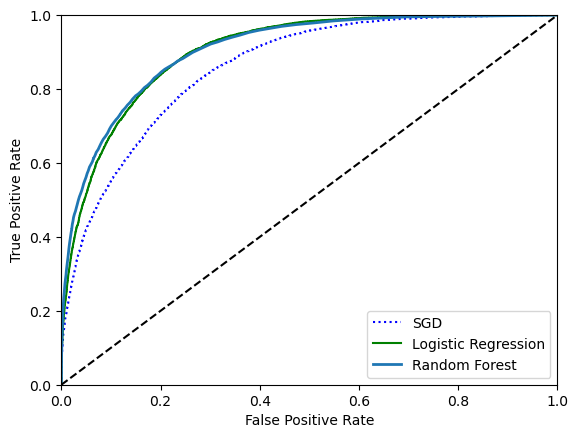

In [223]:
plt.plot(fpr_sgd, tpr_sgd, "b:", label="SGD")
plt.plot(fpr_lg, tpr_lg, "g-", label="Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()